<a href="https://colab.research.google.com/github/cxbxmxcx/Evolutionary-Deep-Learning/blob/main/EDL_5_ES_HPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
#@title Install DEAP
!pip install deap --quiet

     |████████████████████████████████| 163kB 2.8MB/s 


In [ ]:
#@title Defining Imports
#numpy
import numpy as np
#DEAP
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
#PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
#plotting
from matplotlib import pyplot as plt
from IPython.display import clear_output
#utils
import random
import math
import array
import time

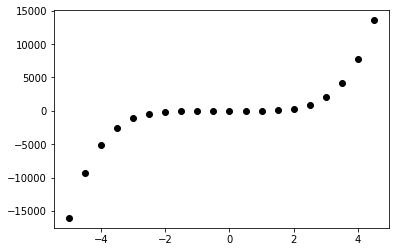

In [ ]:
#@title Setup Target Function and Data
def function(x):
  return (2*x + 3*x**2 + 4*x**3 + 5*x**4 + 6*x**5 + 10) 

data_min = -5
data_max = 5
data_step = .5
Xi = np.reshape(np.arange(data_min, data_max, data_step), (-1, 1))
yi = function(Xi)
inputs = Xi.shape[1]
yi = yi.reshape(-1, 1)
plt.plot(Xi, yi, 'o', color='black')

In [ ]:
#@title Define the Model
class Net(nn.Module):
  def __init__(self, inputs, middle):
    super().__init__()
    self.fc1 = nn.Linear(inputs,middle)    
    self.fc2 = nn.Linear(middle,middle)    
    self.out = nn.Linear(middle,1)
  def forward(self, x):
    x = F.relu(self.fc1(x))     
    x = F.relu(self.fc2(x))    
    x = self.out(x)
    return x

In [ ]:
#@title Define HyperparametersEC Class
class HyperparametersEC(object):
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs) 
    self.hparms = [d for d in self.__dict__]  
        
  def __str__(self):
    out = ""
    for d in self.hparms:
      ds = self.__dict__[d]
      out += f"{d} = {ds}\n"
    return out   

  def size(self):
    return len(self.hparms)

  def next(self, individual):
    dict = {}
    #initialize generators
    for i, d in enumerate(self.hparms):
      next(self.__dict__[d])
    for i, d in enumerate(self.hparms):      
      dict[d] = self.__dict__[d].send(individual[i])
    return HyperparametersEC(**dict)   

def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def linespace(min,max):
  rnge = max - min
  while True:
    i = yield
    i = (clamp(i, -1.0, 1.0) + 1.0) / 2.0
    yield i * rnge + min

def linespace_int(min,max):
  rnge = max - min
  while True:
    i = yield
    i = (clamp(i, -1.0, 1.0) + 1.0) / 2.0
    yield int(i * rnge) + min

def static(val):
  while True:
    yield val

# Create the HyperparamtersEC Object

In [ ]:
#@title Instantiate the HPO
hp = HyperparametersEC(
  middle_layer = linespace_int(12, 64),
  learning_rate = linespace(3.5e-03,3.5e-01),
  batch_size = linespace_int(4, 16),    
  epochs = static(100)  
)

cuda = True if torch.cuda.is_available() else False
print("Using CUDA" if cuda else "Not using CUDA")
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

ind = [-.5, .75, -.1, .8]
print(hp.next(ind))

Using CUDA
middle_layer = 25
learning_rate = 0.3066875
batch_size = 9
epochs = 100



# Setup DEAP for ES Search

In [ ]:
#@title ES Bounding Hyperparameters
IND_SIZE = hp.size()
NGEN = 10
MIN_VALUE = -1
MAX_VALUE = 1
MIN_STRATEGY = 0.5
MAX_STRATEGY = 3

CXPB = .6
MUTPB = .3

In [ ]:
#@title Create the Creator
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", array.array, typecode="d", fitness=creator.FitnessMin, strategy=None)
creator.create("Strategy", array.array, typecode="d")

In [ ]:
#@title Individual generator and decorate functions
def generateES(icls, scls, size, imin, imax, smin, smax):  
  ind = icls(random.uniform(imin, imax) for _ in range(size))  
  ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))  
  return ind

def checkStrategy(minstrategy):
  def decorator(func):
    def wrappper(*args, **kargs):
      children = func(*args, **kargs)
      for child in children:
        for i, s in enumerate(child.strategy):
          if s < minstrategy:
            child.strategy[i] = minstrategy
      return children
    return wrappper
  return decorator

In [ ]:
#@title Setup the Toolbox
print(checkStrategy(MIN_STRATEGY))
toolbox = base.Toolbox()
toolbox.register("individual", generateES, creator.Individual, creator.Strategy,
    IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRATEGY, MAX_STRATEGY)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxESBlend, alpha=0.1)
toolbox.register("mutate", tools.mutESLogNormal, c=1.0, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.decorate("mate", checkStrategy(MIN_STRATEGY))
toolbox.decorate("mutate", checkStrategy(MIN_STRATEGY))

<function checkStrategy.<locals>.decorator at 0x7f75ab04b5f0>


# Create a Training Function

30.787025451660156


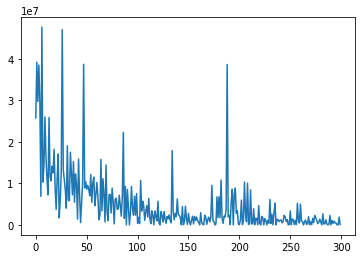

In [ ]:
#@title Wrapper Function for DL
def train_function(hp): 
  X = np.reshape(
      np.arange(
          data_min, 
          data_max, 
          data_step)
      , (-1, 1))
  y = function(X)
  inputs = X.shape[1]
  
  tensor_x = torch.Tensor(X) # transform to torch tensor
  tensor_y = torch.Tensor(y)
  
  dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  dataloader = DataLoader(dataset, batch_size= hp.batch_size, shuffle=True) # create your dataloader

  model = Net(inputs, hp.middle_layer)
  loss_fn = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=hp.learning_rate)
  if cuda:
    model.cuda()
    loss_fn.cuda()
  
  history=[]  
  start = time.time()
  for i in range(hp.epochs):        
    for X, y in iter(dataloader):
      # wrap the data in variables
      x_batch = Variable(torch.Tensor(X).type(Tensor))
      y_batch = Variable(torch.Tensor(y).type(Tensor))                   
      # forward pass
      y_pred = model(x_batch)        
      # compute and print loss
      loss = loss_fn(y_pred, y_batch)  
      ll = loss.data
      history.append(ll)                   
      # reset gradients
      optimizer.zero_grad()        
      # backwards pass
      loss.backward()        
      # step the optimizer - update the weights
      optimizer.step()  
  end = time.time() - start
  return end, history, model, hp

hp_in = hp.next(ind)
span, history, model, hp_out = train_function(hp_in)
plt.plot(history)
print(min(history).item())

# ES Evaluate Function in Toolbox

In [ ]:
#@title Create Evaluation Function and Register
def evaluate(individual):
  hp_in = hp.next(individual)
  span, history, model, hp_out = train_function(hp_in)
  fitness = history[-1].item()
  return fitness,

# fitness eval
toolbox.register("evaluate", evaluate)

# Perform the HPO

Generation: 10/10, Fitness: 39709.9375


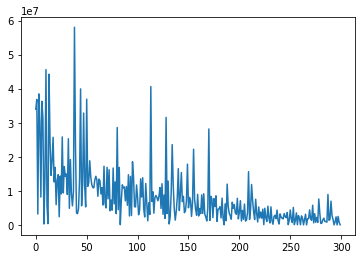

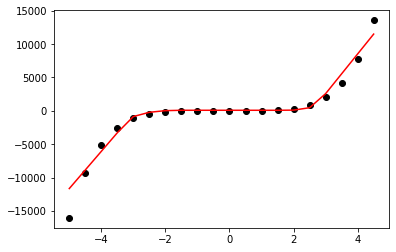

middle_layer = 27
learning_rate = 0.12969573668403092
batch_size = 9
epochs = 100



In [ ]:
random.seed(64)
    
MU, LAMBDA = 5, 10
pop = toolbox.population(n=MU)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

start = time.time()
for g in range(NGEN):
  pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox, mu=MU, lambda_=LAMBDA, 
            cxpb=CXPB, mutpb=MUTPB, ngen=1, stats=stats, halloffame=hof, verbose=False)
  best = hof[0]
  clear_output()
  span, history, model, hp_out = train_function(hp.next(best))
  fitness = history[-1].item()   
  print(f"Generation: {g+1}/{NGEN}, Fitness: {fitness}")
  plt.plot(history)
  plt.show()
  plt.plot(Xi, yi, 'o', color='black')
  y_ = model(torch.Tensor(Xi).type(Tensor))
  plt.plot(Xi,y_.detach().cpu().numpy(), 'r')
  plt.show()
  print(hp_out)    